У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 409.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 47.5 MB/s eta 0:0

In [127]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import plot_acf, check_seasonality
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.metrics import mape
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from statsmodels.graphics.gofplots import qqplot
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate

In [3]:
# load dataset from Kaggle
#dataset_url = 'https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data'
#od.download(dataset_url)
#data_dir = './demand-forecasting-kernels-only/'
#print(f'Files in directory: {os.listdir(data_dir)}')
#raw_df_url = '{}train.csv'.format(data_dir)


raw_df_url = 'https://github.com/roldugina/Machine_learning_course/raw/main/train.csv.zip'
# read dataset from .csv file
raw_df = pd.read_csv(raw_df_url)
print('Original dataset:')
display(raw_df.head(10))

# convert date to datetime format
raw_df['date']=pd.to_datetime(raw_df['date'])
raw_df.set_index('date', inplace = True)

Original dataset:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



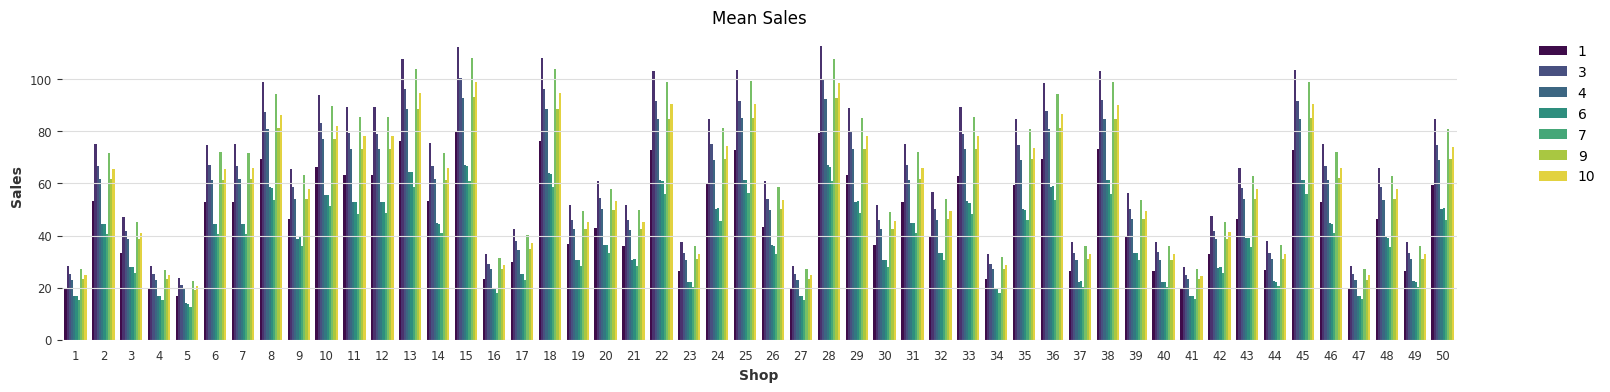

In [95]:
grouped_df = raw_df.groupby(["store", "item"]).agg({'sales':'mean'}).reset_index()
plt.figure(figsize=(18, 4))
sns.barplot(x="item", y="sales", hue="store", data=grouped_df, palette="viridis")
plt.title('Mean Sales')
plt.xlabel('Shop')
plt.ylabel('Sales')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


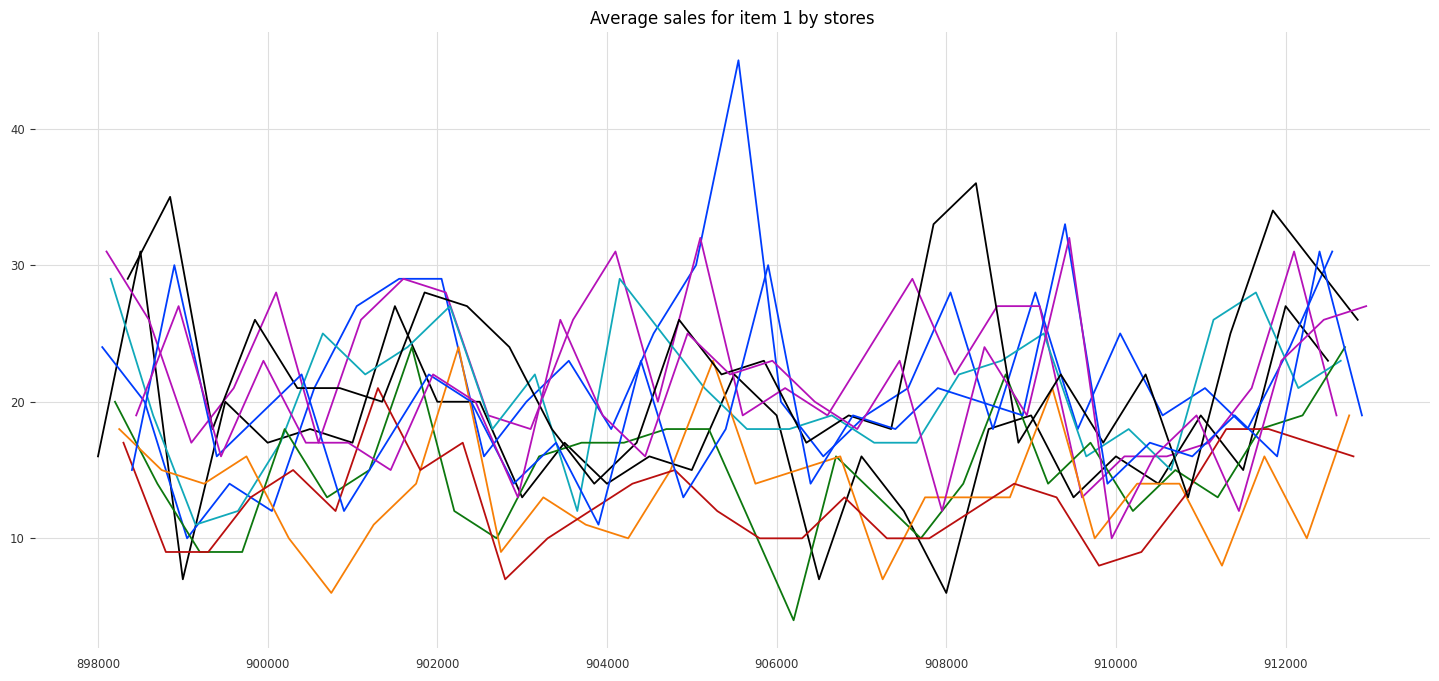

In [132]:

df=raw_df.reset_index()
grouped_df2=df.groupby(['date','store','item'])['sales'].mean().reset_index()

plt.figure(figsize=(18,8))
for i in np.arange(1,11,1):
  grouped_df2[(grouped_df2['item']==1)&(grouped_df2['store']==i)&(grouped_df2['date']>'2017-12-01')]['sales'].plot(x='date',y='sales')
plt.title('Average sales for item 1 by stores')
plt.show()


3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [5]:
mask = (raw_df['item']==1)&(raw_df['store'] == 1)
raw_df_item1_store1 = raw_df[mask]
raw_df_item1_store1

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


In [6]:
def decompose_plot(df, period):
  # decompose data
  decomposed=seasonal_decompose(df, model='additive', period=period)

  # plot decomposed data
  fig = decomposed.plot()
  fig.set_size_inches((14, 6))
  plt.suptitle(f'Decomposition of Time Series with period={period}', fontsize=16)
  fig.tight_layout()
  plt.show()
  qqplot(decomposed.resid.dropna())
  plt.title('Q-Q Plot of Residuals')
  plt.show()
  return decomposed

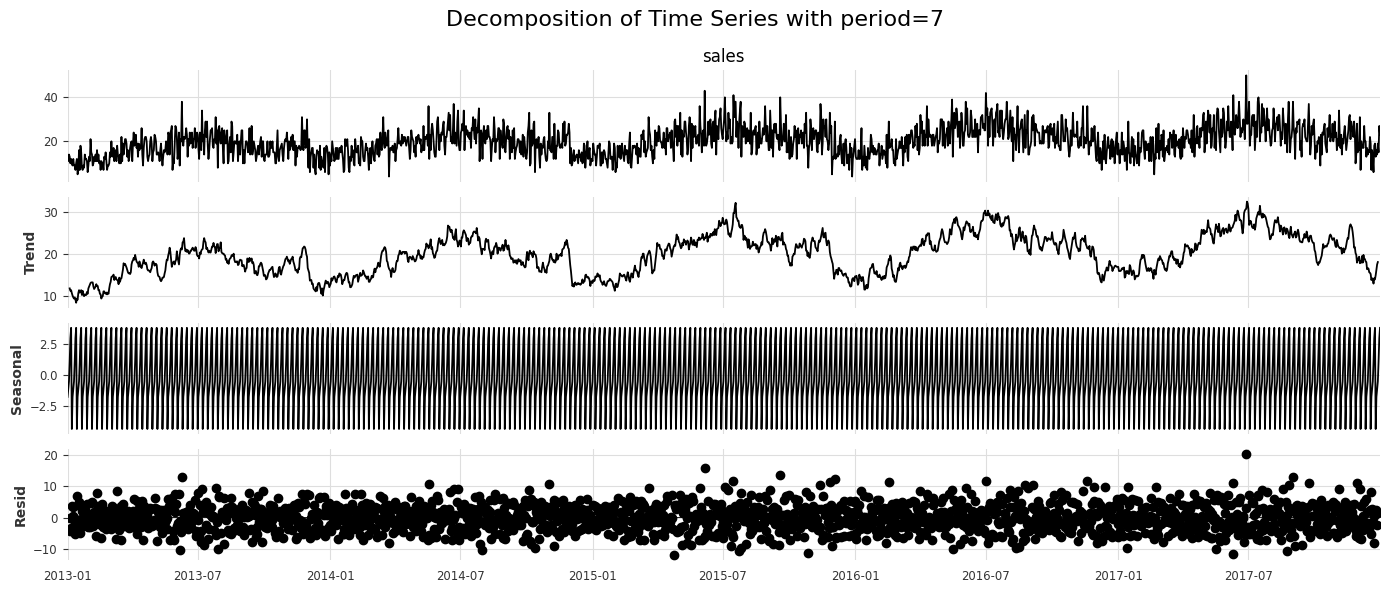

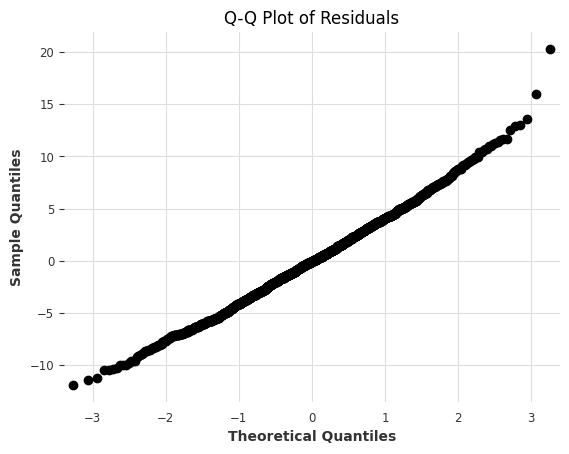

In [7]:
# decompose data with seasonal period =7
decompose_7=decompose_plot(raw_df_item1_store1['sales'],7)

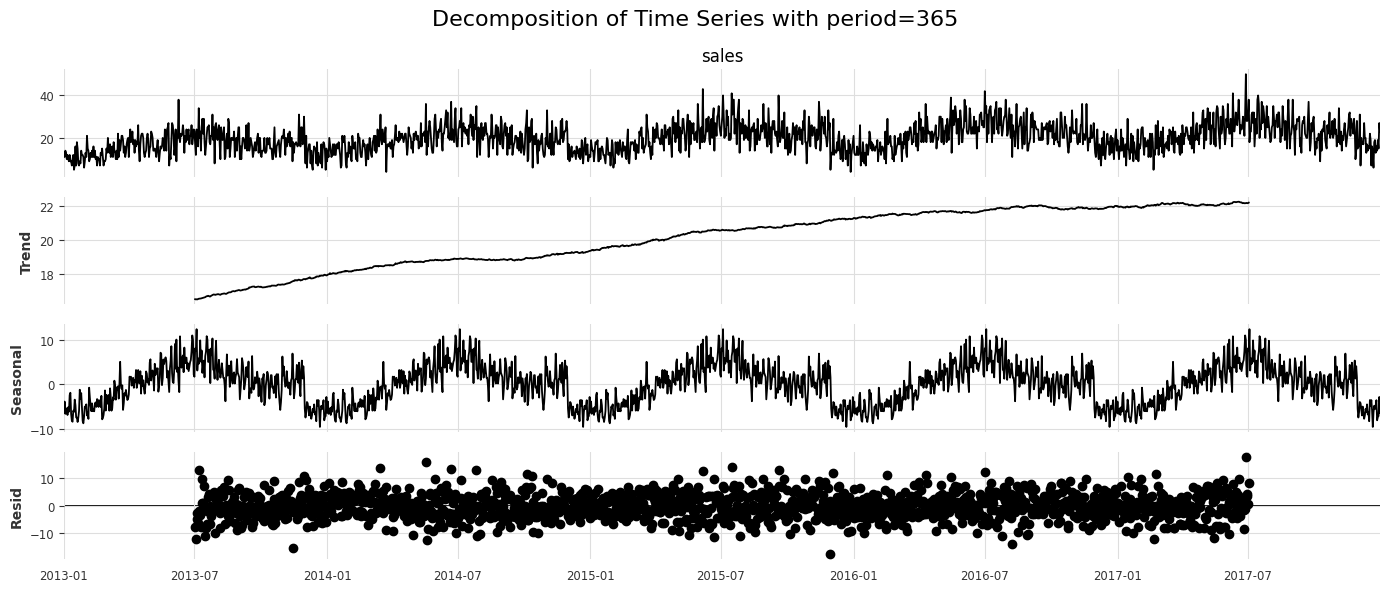

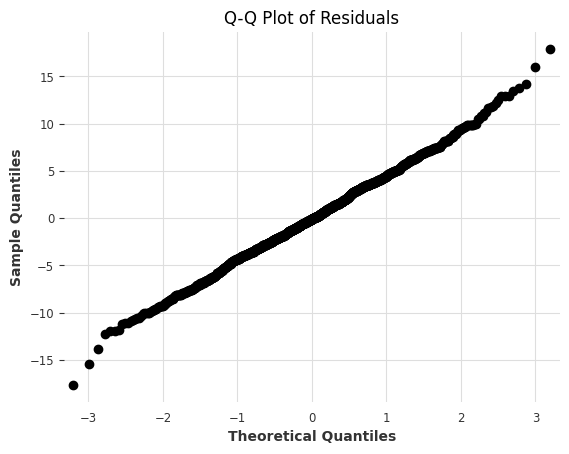

In [8]:
# decompose data with seasonal period=1 year
decompose_365=decompose_plot(raw_df_item1_store1['sales'],365)

**Висновки**

1. Зробили декомпозицію часового ряда та виявили, що є загальний зростаючий тренд, а також 2 сезонних компоненти: тижнева та річна.
2. Залишки наближені до нормальних та не мають паттерна.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [9]:
# create TimeSeries object
series = TimeSeries.from_dataframe(raw_df_item1_store1, value_cols = 'sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

Перший елемент валідаційного набору має тайм-індекс: 2017-10-01 00:00:00


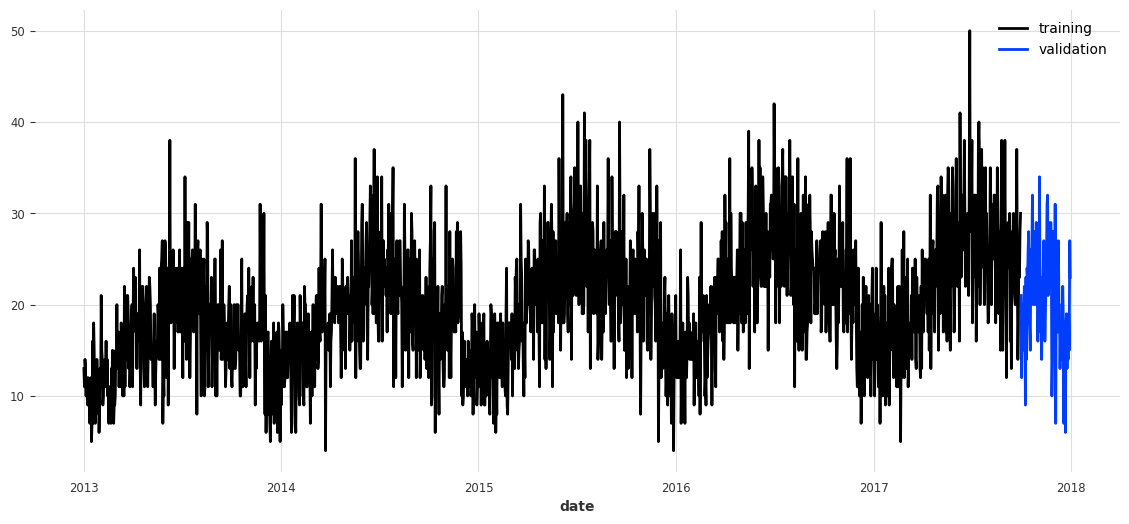

In [10]:
# split series
series_train, series_val = series.split_before(pd.Timestamp('2017-10-01'))
print(f'Перший елемент валідаційного набору має тайм-індекс: {series_val.time_index[0]}')

# visualize train and validation series
plt.figure(figsize=(14,6))
series_train.plot(label="training")
series_val.plot(label="validation")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 3000x600 with 0 Axes>

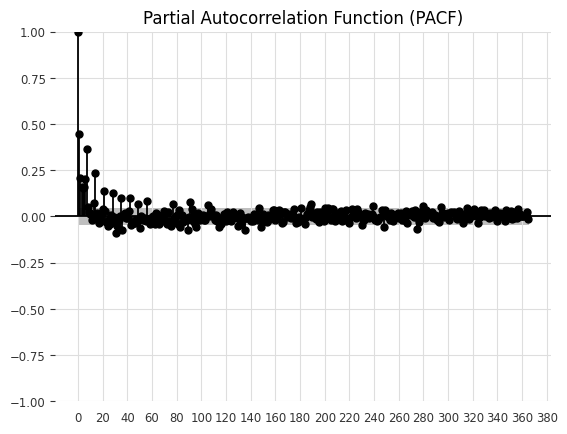

In [11]:
# build partial ACF
plt.figure(figsize=(30, 6))
plot_pacf(series.values(), lags=365, method='ywm')
plt.xticks(ticks=np.arange(0,400,20))
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Висновки**

Статистистично значущими є лаги 0-8, 14, 21, 28, 31, 35, 36, 42.

Можна припустити, що наявна сезонність з періодом 7.

Для прогнозування важливі лаги 0-8 та кратні 7.
Важливість лагів 31 та 36 для прогнозування треба проаналізувати додатково (незрозуміло, чому саме ці лаги є значущими).

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [12]:
for m in range (2,25):
  is_seasonal, period = check_seasonality(series_train, m=m, alpha=0.05)
  if is_seasonal:
    print(f'Identified seasonality at period={period}')

Identified seasonality at period=7
Identified seasonality at period=14
Identified seasonality at period=21


Підтверждена сезональність тренувального ряду з періодом 7.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [13]:
def fit_(model,train,val):
  model.fit(train)
  forecast = model.predict(len(val))
  return forecast

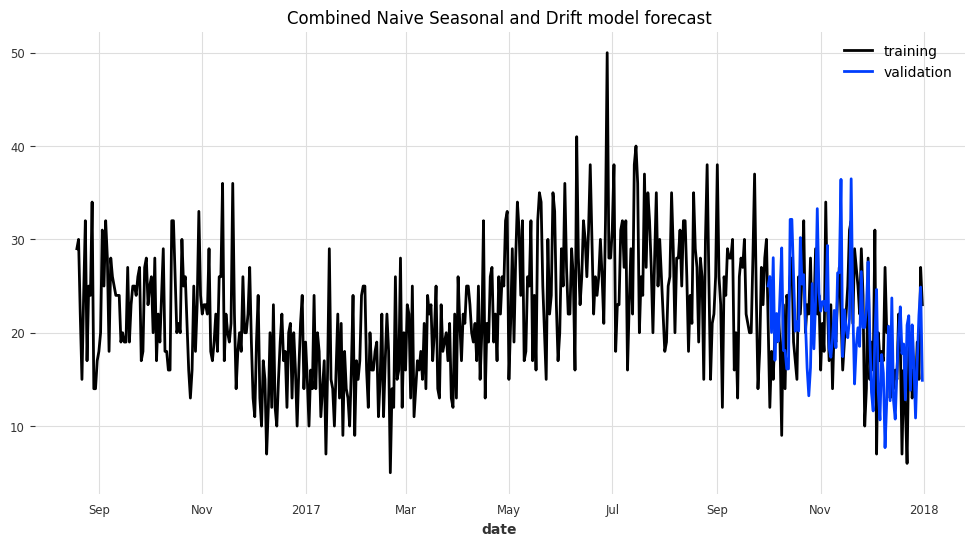

In [14]:
seasonal = NaiveSeasonal(K=365)
drift = NaiveDrift()
seasonal_forecast = fit_(seasonal, series_train, series_val)
drift_forecast = fit_(drift, series_train, series_val)
combined_forecast = seasonal_forecast+drift_forecast-series_train.last_value()


plt.figure(figsize=(12,6))
series[-500:].plot(label="training")
combined_forecast.plot(label="validation")
plt.title('Combined Naive Seasonal and Drift model forecast')
plt.show()

**Висновки**

Модель побачила загальну закономірність даних, але не змогла "схопити" значні коливання у даних.
MAPE моделі дорівнює 34.26%, що свідчить, що модель поки не дуже якісна.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [15]:
def eval_model(val, forecast, model_name):
  mape_ = mape(val, forecast)
  print(f"Model {model_name} obtains MAPE: {mape_:.2f}%")
  return mape_

In [16]:
eval_model(series_val, combined_forecast, 'Combined Naive Seasonal and Drift model');

Model Combined Naive Seasonal and Drift model obtains MAPE: 34.26%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

Model XGBModel obtains MAPE: 24.53%


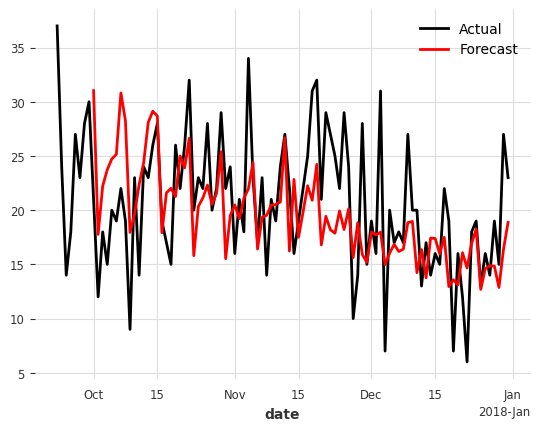

''

In [17]:
def enrich_with_date_features(series):
   series=series.add_datetime_attribute('year')
   series=series.add_datetime_attribute('quarter')
   series=series.add_datetime_attribute('month')
   series=series.add_datetime_attribute('week')
   series=series.add_datetime_attribute('dayofyear')
   series=series.add_datetime_attribute('dayofweek')
   series=series.add_holidays('US')
   #series=series.stack(lambda ts: TimeSeries.from_times_and_values(ts.time_index, np.sin(ts.time_index.dayofyear)))
   #sin, cos, trend
   series = series.stack(TimeSeries.from_times_and_values(series.time_index, np.sin(series.time_index.dayofyear)+1, columns='sin_dayofyear'))
   series = series.stack(TimeSeries.from_times_and_values(series.time_index, np.cos(series.time_index.dayofyear)+1, columns='cos_dayofyear'))
   return series

train_transformed = enrich_with_date_features(series_train)
val_transformed = enrich_with_date_features(series_val)

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train_transformed)
val_transformed = scaler.transform(val_transformed)

lags = np.arange(-1, -15, -1).tolist()
lags.append(-365)

# Побудова моделі XGBoost
model_xgb = XGBModel(
    lags=lags,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=300,  # Кількість дерев у моделі
    max_depth=5,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model_xgb.fit(train_transformed)
xgb_forecast = scaler.inverse_transform(model_xgb.predict(len(series_val)))
eval_model(series_val, xgb_forecast['sales'],type(model_xgb).__name__)
series[-100:]['sales'].plot(label='Actual')
xgb_forecast['sales'].plot(label='Forecast', color='red')
plt.legend()
plt.show()
;



**Висновки**

1. Модель має кращий показник MAPE, ніж наївна модель: 24.53% проти 34.26%, але цей показник і досі не дуже високий.
2. Модель бачить загальну тенденцію, але не може повторити великі коливання у часових даних. З часом модель "згладжує" коливання даних, що призводить до ще більшої помилки.
3. Для покращення моделі можна експериментувати з коваріатами, а також підбирати оптимальні гіперпараметри.




11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [18]:
def plot_results(series, forecast):
  # Візуалізація результатів
  plt.figure(figsize=(12,6))
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast=model.predict(len(val))
  plot_results(series, forecast)
  eval_model(val, forecast, type(model).__name__)

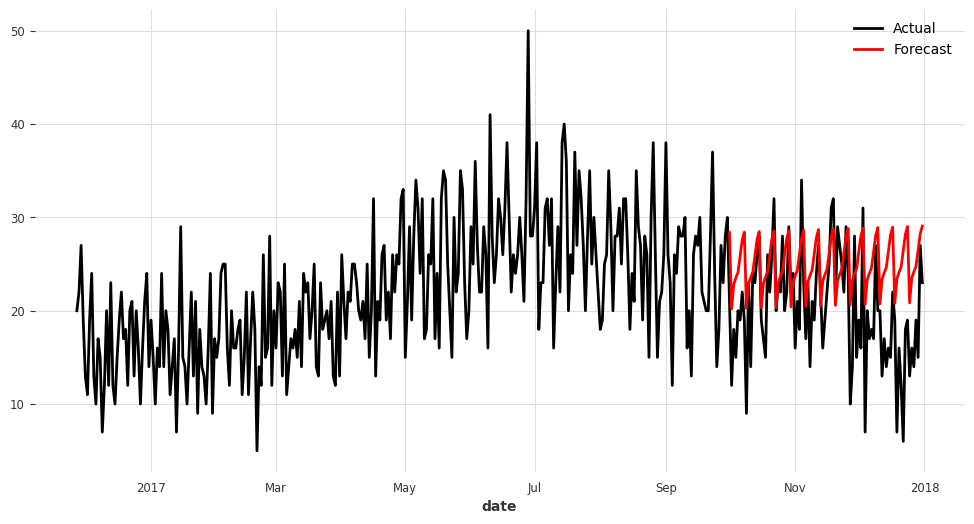

Model ExponentialSmoothing obtains MAPE: 39.01%


In [19]:
model = ExponentialSmoothing()
fit_and_plot(model, series[-400:], series_train, series_val)

**Висновки**

Модель має досить високий рівень MAPE, що говорить про її низьку точність.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

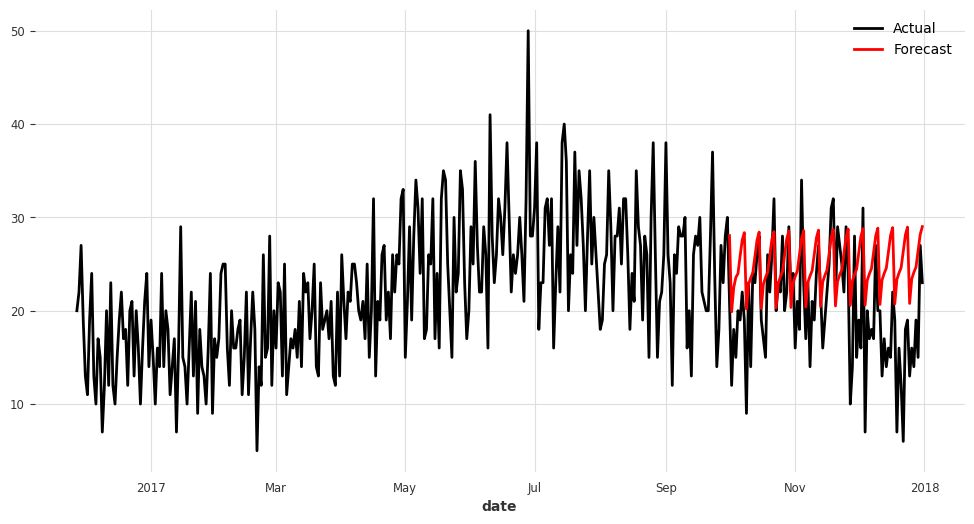

Model ARIMA obtains MAPE: 38.74%


In [25]:
model = ARIMA(1,1,5, seasonal_order=(1,1,1,7))
fit_and_plot(model, series[-400:], series_train, series_val)

**Висновки**

Модель має досить високий рівень MAPE, що говорить про її низьку точність.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

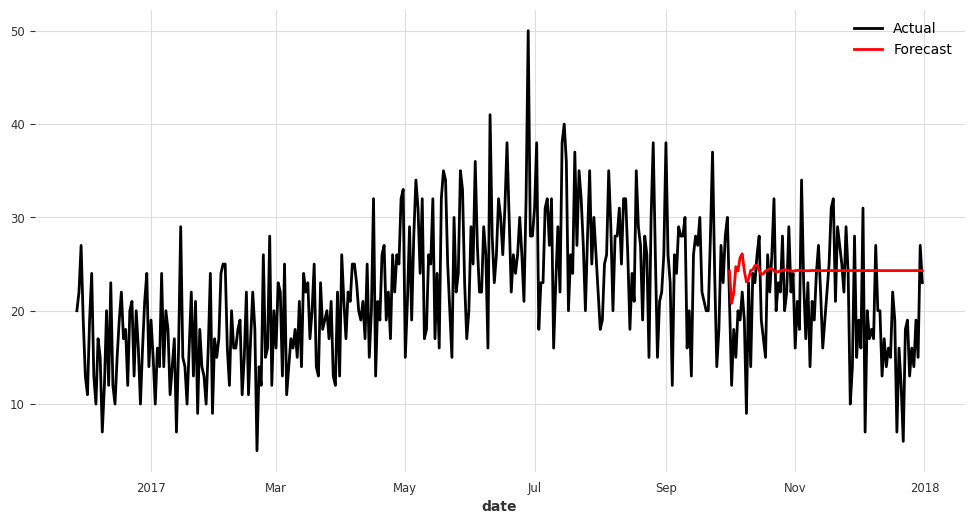

Model AutoARIMA obtains MAPE: 39.53%


In [21]:
model = AutoARIMA(start_p=1, max_p=12, start_q=1)
fit_and_plot(model, series[-400:], series_train, series_val)

З використанням моделі AutoARIMA не вдалось покращити попередній результат. Рівень MAPE ще трохи виріс та склав 39.53%

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/6asll066.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/juj0gezn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91433', 'data', 'file=/tmp/tmp7r1eng5l/6asll066.json', 'init=/tmp/tmp7r1eng5l/juj0gezn.json', 'output', 'file=/tmp/tmp7r1eng5l/prophet_modellr38b75k/prophet_model-20240821210925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


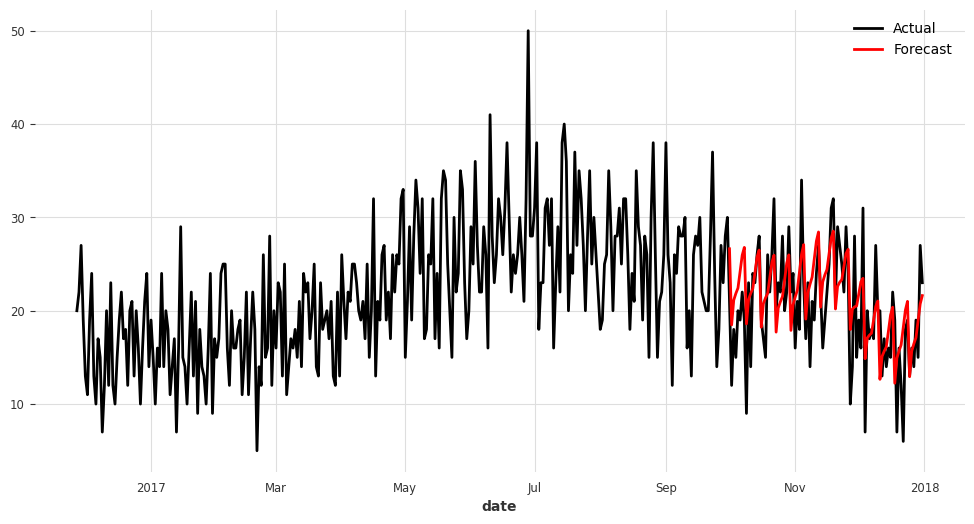

Model Prophet obtains MAPE: 23.80%


In [22]:
model = Prophet()
fit_and_plot(model, series[-400:], series_train, series_val)

**Висновки**

З усіх моделей, які були розглянуті, ця модель має найкращий рівень MAPE=23.8%

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

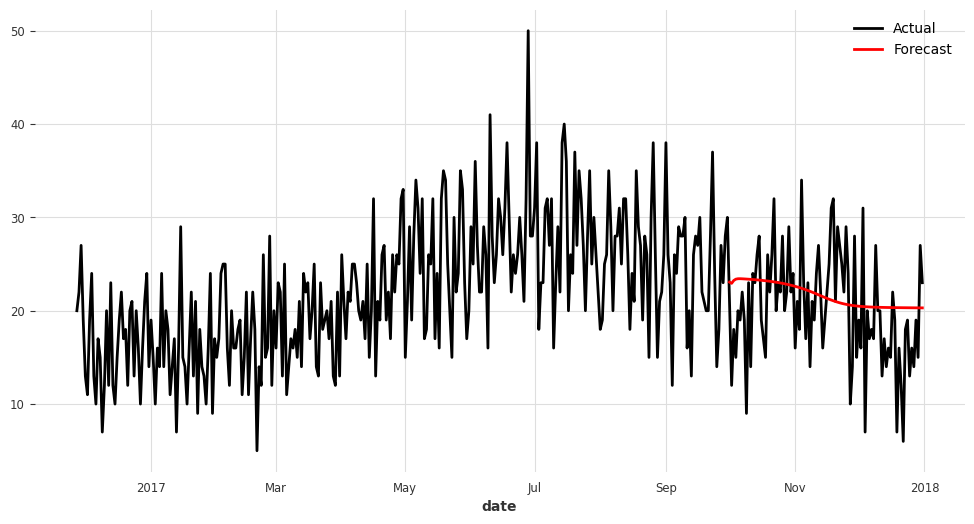

Model RNNModel obtains MAPE: 30.27%


In [23]:
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=100)
fit_and_plot(model, series[-400:], series_train, series_val)

**Висновки**

1. З даними налаштуваннями модель спрогнозувала загальний тренд, але зовсім не змогла спрогнозувати сезонні коливання, тобто потребує подальшого налаштування.
2. Невисокий рівень MAPE (30.27%).

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/cfv_galh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/p_1q5lz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92647', 'data', 'file=/tmp/tmp7r1eng5l/cfv_galh.json', 'init=/tmp/tmp7r1eng5l/p_1q5lz8.json', 'output', 'file=/tmp/tmp7r1eng5l/prophet_modelwyhse_65/prophet_model-20240821224722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/4ya1bpz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/4a4g063j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

MAPE = 24.45%


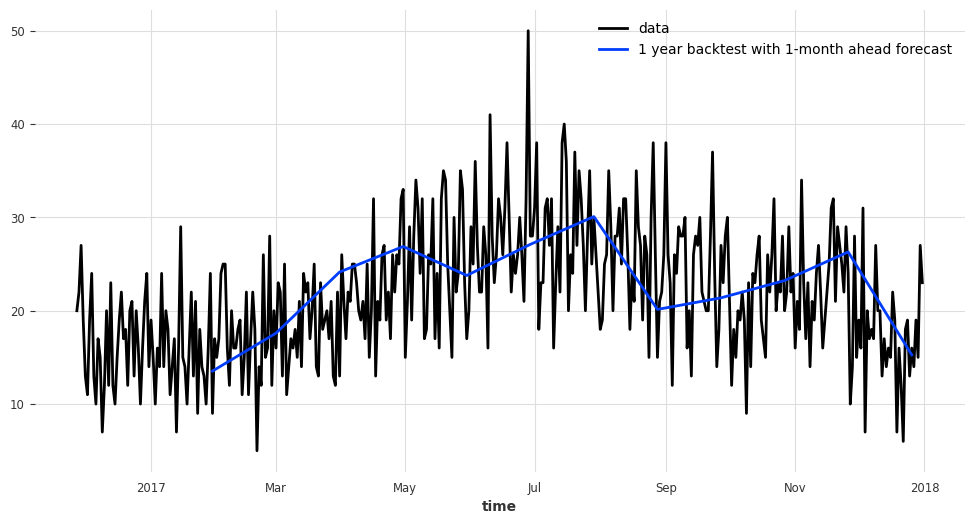

In [58]:
backtest_horizon=365
forecast_horizon=30
start = series.time_index[-backtest_horizon]
model = Prophet(daily_seasonality=True)
model.fit(series_train)
pred=model.predict(len(series_val))

hfc_params = {
    "series": series,
    "forecast_horizon": forecast_horizon,
    "start": start,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, stride=forecast_horizon,  **hfc_params)
plt.figure(figsize=(12,6))
series[-400:].plot(label="data")
historical_fcast.plot(label="1 year backtest with 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")



  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/mpe98yh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/63okmca0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3387', 'data', 'file=/tmp/tmp7r1eng5l/mpe98yh0.json', 'init=/tmp/tmp7r1eng5l/63okmca0.json', 'output', 'file=/tmp/tmp7r1eng5l/prophet_model6n17f8_s/prophet_model-20240821224739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.67it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/objtmc9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/om6y49ov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdst

MAPE = 21.09%


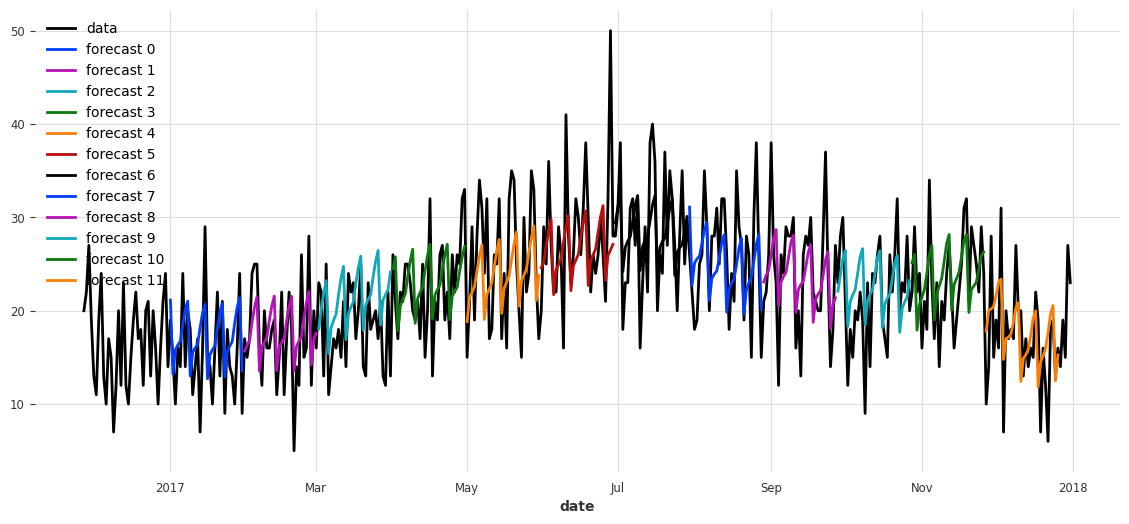

In [59]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=forecast_horizon, **hfc_params)

plt.figure(figsize=(14,6))
series[-400:].plot(label="data")

for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

  0%|          | 0/336 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/en20feeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/s6p_68k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71735', 'data', 'file=/tmp/tmp7r1eng5l/en20feeu.json', 'init=/tmp/tmp7r1eng5l/s6p_68k6.json', 'output', 'file=/tmp/tmp7r1eng5l/prophet_model5k_o963j/prophet_model-20240821225213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/336 [00:00<01:55,  2.91it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/nt5mivq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7r1eng5l/za10j0ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cm

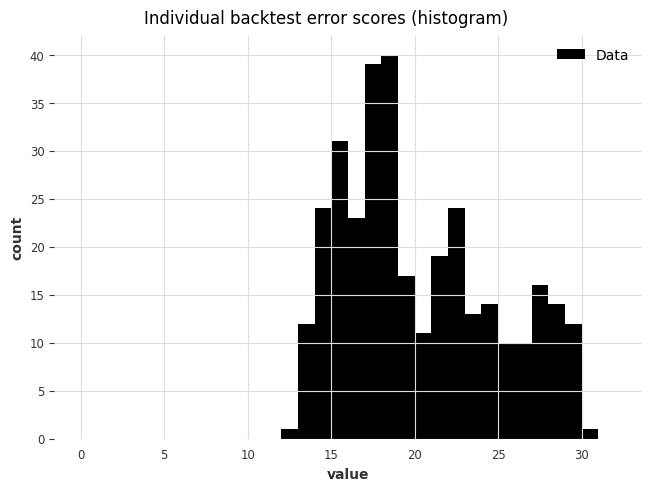

In [60]:
raw_errors = model.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)
from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

**Висновки**

1. Для бектесту обрала модель Prophet, вона показала найкращий результат.
2. При запуску бектесту з параметром last_points_only=False ми отримали "згладжений" результат, тому що в результат попадають тільки останні значення за період.
3. З параметром last_points_only=True результат включає сезонну варіативність.
4. Параметр MAPE склав 24.45%, що трохи вище, ніж після навчання на всьому тренувальному наборі (був 23.8%).
5. Помилки розподілені в інтервалі 12%-30%.

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Якщо використовувати моделі для прогнозування timeseries, то для прогнозування для кожного товару з усіх магазинів необхідно було натренувати 50*10=500 моделей, що дуже затратно по часу.
Тому можна використати XGBoost або LightGBM.